# Metadata

```yaml
Course:   DS 5001
Module:   11 Lab
Topc:     TextBlob
Author:   R.C. Alvarado
Date:     10 April 2024
```

**Purpose:** Demonstrate use of TextBlob for SA and other tasks.

# Textblob

> TextBlob is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, and more.

> TextBlob aims to provide access to common text-processing operations through a familiar interface. You can treat TextBlob objects as if they were Python strings that learned how to do Natural Language Processing. 

[Source](https://textblob.readthedocs.io/en/dev/).

TextBlob uses the [Pattern](https://github.com/clips/pattern) library and [SentiWordNet](https://github.com/aesuli/sentiwordnet) lexicon to compute sentiment. 

It computes average polarity and subjectivity over each word in a given text using a dictionary of adjectives and their hand-tagged scores. 

The lexicon is [here](https://raw.githubusercontent.com/aesuli/SentiWordNet/master/data/SentiWordNet_3.0.0.txt).

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
text_file =  f"{data_home}/syuzhet/R/persuasion.txt"

In [3]:
import pandas as pd
from textblob import Blobber

# Create Object

In [4]:
blobber = Blobber()

In [5]:
# blobber(open(text_file, 'r').read()).polarity

In [6]:
TB = blobber(open(text_file, 'r').read())

In [7]:
' '.join([a for a in TB.__dir__() if '__' not in a])

'raw string stripped tokenizer np_extractor pos_tagger analyzer parser classifier sentences words raw_sentences serialized to_json json _create_sentence_objects tokens tokenize parse classify sentiment sentiment_assessments polarity subjectivity noun_phrases pos_tags tags word_counts np_counts ngrams correct _cmpkey _strkey split find rfind index rindex startswith endswith starts_with ends_with title format strip upper lower join replace _compare'

# Extract Tables

## DOC

In [8]:
import json

In [9]:
DOC = pd.DataFrame(json.loads(TB.to_json()))
DOC.index.name = 'sent_id'

## NP (Noun Phrases)

In [10]:
NP = DOC.noun_phrases.apply(pd.Series).stack().to_frame('np_str')
NP.index.names = ['sent_id', 'np_num']

In [11]:
NP_VOCAB = NP.np_str.value_counts().to_frame('n')

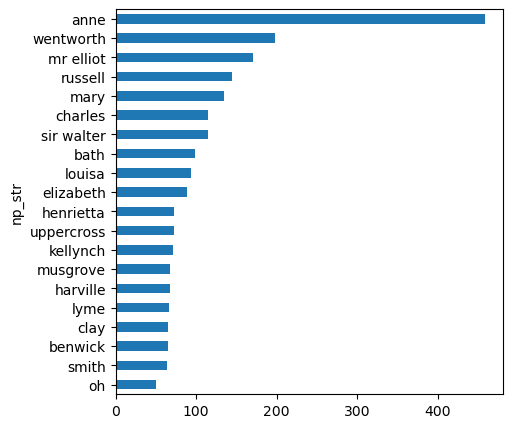

In [12]:
NP_VOCAB.head(20).sort_values('n').plot.barh(figsize=(5, 5), legend=False);

In [13]:
# NPM = NP.groupby(['sent_id', 'np_str']).np_str.count().unstack(fill_value=0)

In [14]:
# NPM

In [15]:
# DOC = pd.DataFrame(dict(sent_str=[s.raw for s in TB.sentences]))
# DOC.index.name = 'sent_num'
# DOC['polarity'] = [s.polarity for s in TB.sentences]
# DOC['subjectivity'] = [s.subjectivity for s in TB.sentences]
# DOC

In [16]:
# TB.sentences[100].ngrams(5) #__dir__()

## TOKEN

In [17]:
TOKEN = pd.DataFrame(
    [(sent_num, token_num, *pair) 
     for sent_num, sentence in enumerate(TB.sentences) 
     for token_num, pair in enumerate(sentence.tags)],
    columns=['sent_num', 'token_num', 'token_str', 'pos'])\
    .set_index(['sent_num', 'token_num'])

In [18]:
TOKEN

token_str   pos
sent_num token_num                  
0        0             Chapter    NN
         1                   1    CD
         2                 Sir   NNP
         3              Walter   NNP
         4              Elliot   NNP
...                        ...   ...
3651     32               than    IN
         33                 in    IN
         34                its  PRP$
         35           national    JJ
         36         importance    NN

[83830 rows x 2 columns]

In [19]:
TOKEN2 = pd.DataFrame(
    [(sent_num, token_num, *parse[0]) 
     for sent_num, sentence in enumerate(TB.sentences) 
     for token_num, parse in enumerate(sentence.parse().split())],
    columns=['sent_num', 'token_num', 'token_str', 'pos', 'parse_tree', 'parse_tree2'])\
    .set_index(['sent_num', 'token_num'])

In [20]:
TOKEN2

token_str   pos parse_tree parse_tree2
sent_num token_num                                       
0        0           Chapter    NN       B-NP           O
         1               Sir   NNP       B-NP           O
1        0              This    DT          O           O
         1                 "     "          O           O
2        0                 "     "          O           O
...                      ...   ...        ...         ...
3647     0               She   PRP       B-NP           O
3648     0               Her  PRP$       B-NP           O
3649     0              Anne   NNP       B-NP           O
3650     0               His  PRP$       B-NP           O
3651     0               She   PRP       B-NP           O

[4274 rows x 4 columns]

In [21]:
TOKEN2.parse_tree.value_counts()

parse_tree
B-NP      2196
O         1459
B-PP       253
B-VP       180
B-ADVP     152
B-ADJP      34
Name: count, dtype: int64

In [22]:
TOKEN2.value_counts(['parse_tree', 'parse_tree2']).unstack(fill_value=0)

parse_tree2,B-PNP,O
parse_tree,,
B-ADJP,0,34
B-ADVP,0,152
B-NP,0,2196
B-PP,208,45
B-VP,0,180
O,0,1459


In [23]:
TOKEN['term_str'] = TOKEN.token_str.str.replace(r"\W", "").str.lower().str.strip()

In [24]:
TOKEN

token_str   pos    term_str
sent_num token_num                              
0        0             Chapter    NN     chapter
         1                   1    CD           1
         2                 Sir   NNP         sir
         3              Walter   NNP      walter
         4              Elliot   NNP      elliot
...                        ...   ...         ...
3651     32               than    IN        than
         33                 in    IN          in
         34                its  PRP$         its
         35           national    JJ    national
         36         importance    NN  importance

[83830 rows x 3 columns]

## VOCAB

In [25]:
VOCAB = pd.DataFrame(TB.word_counts.items(), columns=['term_str', 'n']).set_index('term_str')

In [26]:
VOCAB

,n
term_str,
chapter,24
1,3
sir,149
walter,138
elliot,286
...,...
supplies,1
defiance,1
accessions,1


# Sentiment

In [27]:
from pyzhet import SyuzhetBook, Transforms

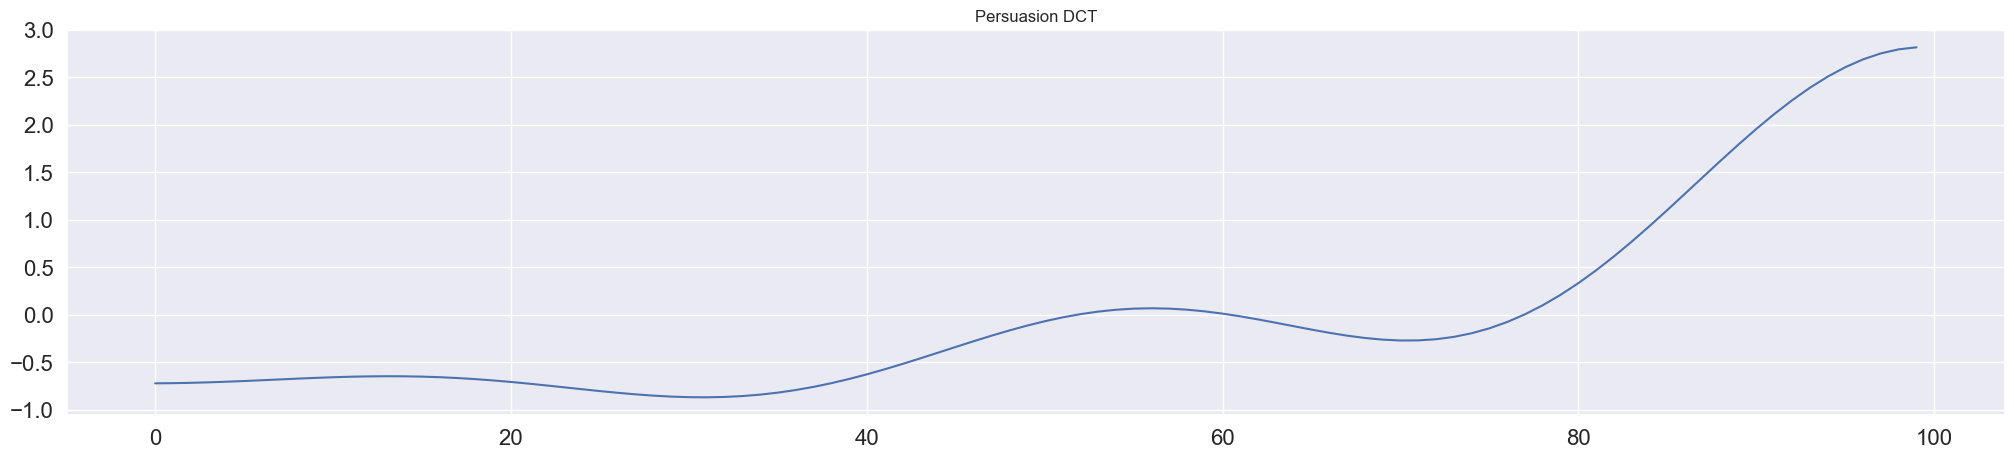

In [28]:
SyuzhetBook(DOC.polarity, 'Persuasion').plot_smooth(low_pass_size=6)

# Explore Our Texts

In [29]:
L = pd.read_csv(f"{data_home}/syuzhet/combo-LIB.csv")\
    .set_index(['book_id'])
S = pd.read_csv(f"{data_home}/syuzhet/combo-SENTENCES.csv")\
    .set_index(['book_id', 'chap_num', 'para_num', 'sent_num'])

In [30]:
S['polarity'] = S.sent_str.apply(lambda x: blobber(x).polarity)

In [31]:
S

sent_str  \
book_id chap_num para_num sent_num                                                      
105     1        1        0         sir walter elliot of kellynch hall in somerset...   
                          1         this was the page at which the favourite volum...   
                 2        0                                  elliot of kellynch hall    
                 3        0         walter elliot born march 1 1760 married july 1...   
                          1         of south park in the county of gloucester by w...   
...                                                                               ...   
usher   1        47       0         from that chamber and from that mansion i fled...   
                          1         the storm was still abroad in all its wrath as...   
                          2         suddenly there shot along the path a wild ligh...   
                          3         the radiance was that of the full setting and ...   
                          4         while i gazed this fissure rapidly widened the...   

                                    polarity  
book_id chap_num para_num sent_num            
105     1        1        0         0.057143  
                          1         0.000000  
                 2        0         0.000000  
                 3        0         0.250000  
                          1         0.000000  
...                                      ...  
usher   1        47       0        -0.600000  
                          1         0.100000  
                          2         0.050000  
                          3        -0.055000  
                          4         0.092857  

[181987 rows x 2 columns]

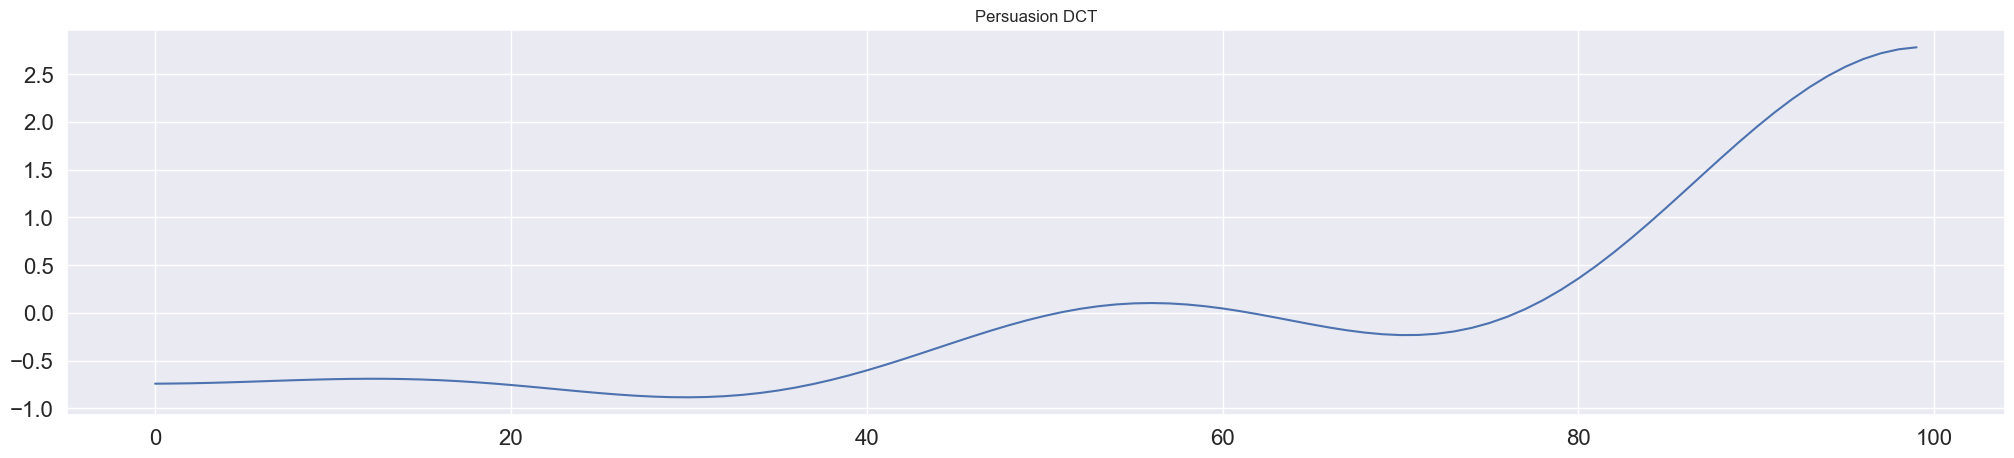

In [32]:
SyuzhetBook(S.loc['105'].polarity, 'Persuasion').plot_smooth(low_pass_size=6)

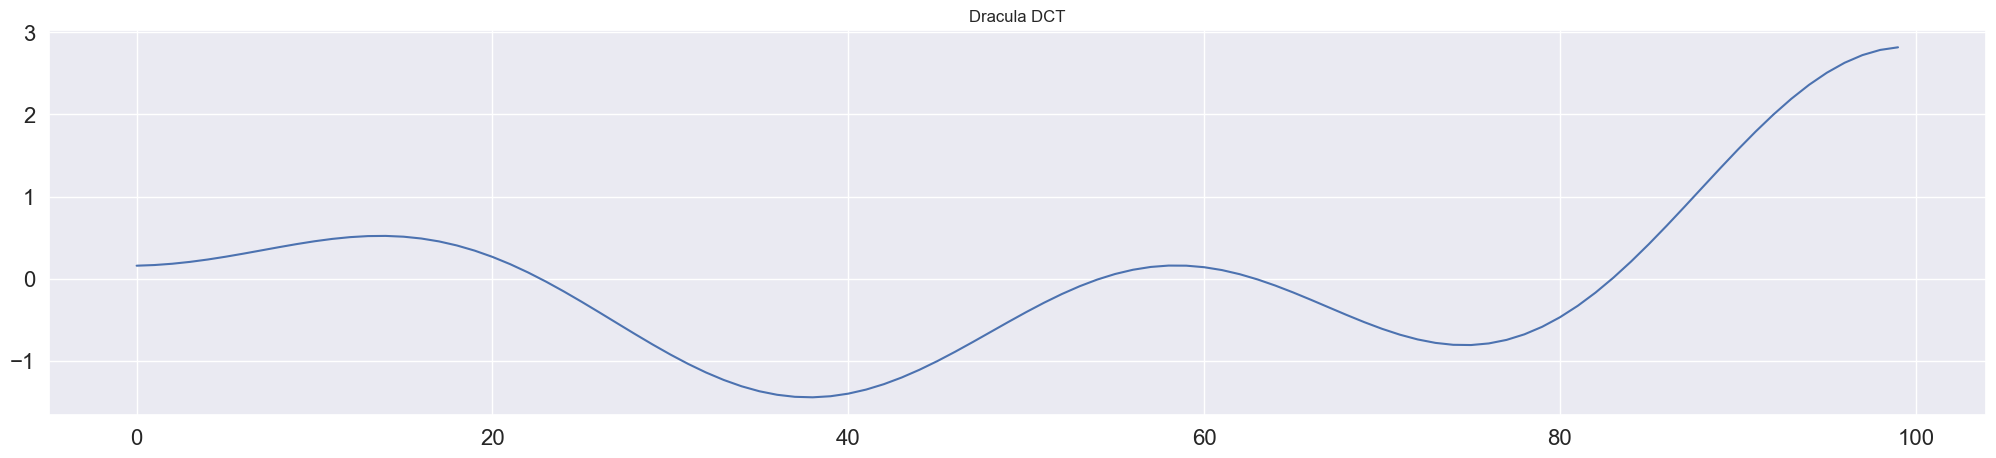

In [33]:
SyuzhetBook(S.loc['dracula'].polarity, 'Dracula').plot_smooth(low_pass_size=6)

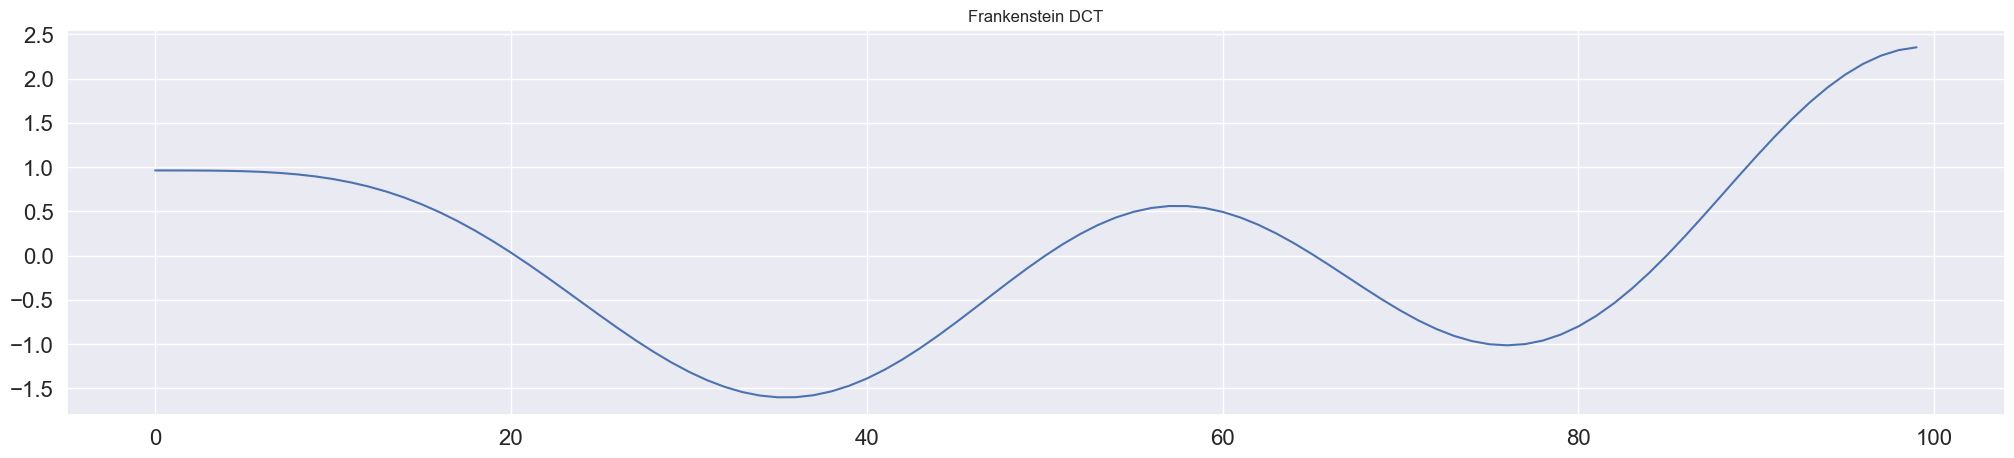

In [34]:
SyuzhetBook(S.loc['frankenstein'].polarity, 'Frankenstein').plot_smooth(low_pass_size=6)